In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['jigsaw-toxic-comment-classification-challenge']


In [2]:
import sys, os, re ,csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

Using TensorFlow backend.


In [3]:
#data location check
import os
print(os.listdir("../input/jigsaw-toxic-comment-classification-challenge/jigsaw-toxic-comment-classification-challenge"))

['train.csv', 'sample_submission.csv', 'test.csv', 'test_labels.csv']


In [4]:
#data loading
train = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/jigsaw-toxic-comment-classification-challenge/train.csv')
test = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/jigsaw-toxic-comment-classification-challenge/test.csv')

In [5]:
train.head(20)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [6]:
test.head(10)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
5,0001ea8717f6de06,Thank you for understanding. I think very high...
6,00024115d4cbde0f,Please do not add nonsense to Wikipedia. Such ...
7,000247e83dcc1211,:Dear god this site is horrible.
8,00025358d4737918,""" \n Only a fool can believe in such numbers. ..."
9,00026d1092fe71cc,== Double Redirects == \n\n When fixing double...


## Data Preprocesssing
- Check for null values

In [7]:
train.isnull().any()
#no null value for train dataset

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

In [8]:
test.isnull().any()
#no null value for test dataset

id              False
comment_text    False
dtype: bool

In [9]:
#split up variables
list_classes = ["toxic","severe_toxic","obscene", "threat", "insult", "identity_hate"]
#change into array values 붙여줄 경우 배열로 바뀜
y = train[list_classes].values
list_sentences_train = train["comment_text"]
list_sentences_test = test["comment_text"]

### 1. Tokenization
We cannot feed the words as it is : breaking down the sentence into words is essential.
ex) I love cats and love dogs -> ["i","love","cats","and","dogs"]

Thankfully, Keras has made everything much simplier!
> http://faroit.com/keras-docs/1.2.2/preprocessing/text/

In [10]:
#define the number of unique words when tokenizing
max_features = 200000
#Class for vectorizing texts, or/and turning texts into sequences (=list of word indexes)
tokenizer = Tokenizer(num_words = max_features, lower=True)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

In [11]:
#for occurence of words
tokenizer.word_counts

OrderedDict([('explanation', 1771),
             ('why', 17818),
             ('the', 496540),
             ('edits', 9957),
             ('made', 9678),
             ('under', 7001),
             ('my', 45619),
             ('username', 1823),
             ('hardcore', 166),
             ('metallica', 35),
             ('fan', 1025),
             ('were', 15421),
             ('reverted', 3902),
             ('they', 27318),
             ("weren't", 424),
             ('vandalisms', 38),
             ('just', 27806),
             ('closure', 88),
             ('on', 89968),
             ('some', 22586),
             ('gas', 331),
             ('after', 8490),
             ('i', 204397),
             ('voted', 302),
             ('at', 39545),
             ('new', 10665),
             ('york', 912),
             ('dolls', 24),
             ('fac', 321),
             ('and', 224192),
             ('please', 29780),
             ("don't", 22917),
             ('remove', 5140),
          

In [12]:
#for index of words
tokenizer.word_index

{'the': 1,
 'to': 2,
 'of': 3,
 'and': 4,
 'a': 5,
 'you': 6,
 'i': 7,
 'is': 8,
 'that': 9,
 'in': 10,
 'it': 11,
 'for': 12,
 'this': 13,
 'not': 14,
 'on': 15,
 'be': 16,
 'as': 17,
 'have': 18,
 'are': 19,
 'your': 20,
 'with': 21,
 'if': 22,
 'article': 23,
 'was': 24,
 'or': 25,
 'but': 26,
 'page': 27,
 'wikipedia': 28,
 'my': 29,
 'an': 30,
 'from': 31,
 'by': 32,
 'do': 33,
 'at': 34,
 'me': 35,
 'about': 36,
 'so': 37,
 'talk': 38,
 'what': 39,
 'can': 40,
 'there': 41,
 'all': 42,
 'has': 43,
 'will': 44,
 'please': 45,
 'no': 46,
 'would': 47,
 'one': 48,
 'like': 49,
 'just': 50,
 'they': 51,
 'he': 52,
 'which': 53,
 'any': 54,
 'been': 55,
 'should': 56,
 'more': 57,
 'we': 58,
 "don't": 59,
 'some': 60,
 'other': 61,
 'who': 62,
 'here': 63,
 'see': 64,
 'also': 65,
 'his': 66,
 'think': 67,
 'because': 68,
 'know': 69,
 'how': 70,
 'edit': 71,
 'am': 72,
 "i'm": 73,
 'people': 74,
 'why': 75,
 'up': 76,
 'only': 77,
 "it's": 78,
 'out': 79,
 'articles': 80,
 'use': 81,

In [13]:
#original
train["comment_text"][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [14]:
#index reprensented style
list_tokenized_train[:1]

[[688,
  75,
  1,
  126,
  130,
  177,
  29,
  672,
  4511,
  12052,
  1116,
  86,
  331,
  51,
  2278,
  11448,
  50,
  6864,
  15,
  60,
  2756,
  148,
  7,
  2937,
  34,
  117,
  1221,
  15190,
  2825,
  4,
  45,
  59,
  244,
  1,
  365,
  31,
  1,
  38,
  27,
  143,
  73,
  3462,
  89,
  3085,
  4583,
  2273,
  985]]

Of course Indexed-sentences would have different length, which may be problematic.

Let's convert them to have consistent length using **padding**!

Before we use padding, we need to see see the distribution of the number of words in sentences to set the best 'maxlen' for later.

In [15]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]

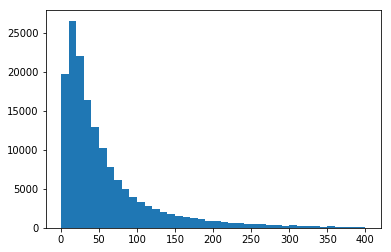

In [16]:
plt.hist(totalNumWords,bins = np.arange(0,410,10))#[0,50,100,150,200,250,300,350,400])#,450,500,550,600,650,700,750,800,850,900])
plt.show()
#we could do 50, but may lose too many features
#so we go with 200 to contain as many features as we can

In [17]:
maxlen = 200
#if (len < maxlen) fill the shortfall by zeros; else trim; 
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [18]:
X_t

array([[    0,     0,     0, ...,  4583,  2273,   985],
       [    0,     0,     0, ...,   589,  8377,   182],
       [    0,     0,     0, ...,     1,   737,   468],
       ...,
       [    0,     0,     0, ...,  3509, 13675,  4528],
       [    0,     0,     0, ...,   151,    34,    11],
       [    0,     0,     0, ...,  1627,  2056,    88]], dtype=int32)

## Build a model now
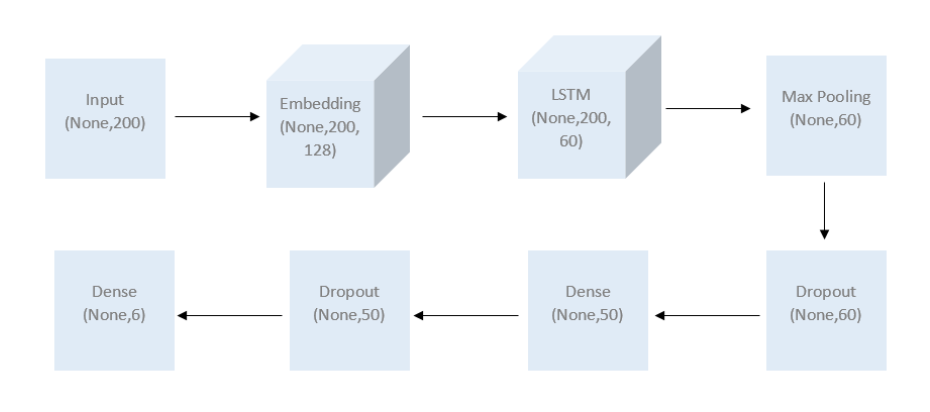

### Word Embedding?
> https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/

**Word Embeddings are the texts converted into numbers and there may be different numerical representations of the same text**

In [19]:
#input layer that accepts a list of sentences that has dimension of 200
inp = Input(shape=(maxlen, )) 
#embedding layer
embed_size = 128
x = Embedding(max_features, embed_size)(inp)
#LSTM -> (None, 200, 60), 60 is the output dimension we define
#recursively feeding the output of a previous network
x = LSTM(60, return_sequences=True,name='lstm_layer')(x)
#3D->2D
x = GlobalMaxPool1D()(x)
#dropout = disconnecting some nodes
x = Dropout(0.1)(x)
#dense layer for output dimension of 50 
x = Dense(50, activation="relu")(x)
#dropout again
x = Dropout(0.1)(x)
#to achieve a binary classification(1,0) for each of the 6 labels
x = Dense(6, activation="sigmoid")(x)
#optimizing
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
#hypertuning
batch_size = 50
epochs = 2
model.fit(X_t,y,batch_size=batch_size,epochs=epochs, validation_split=0.1)

Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143613/143613 [==============================] - 1545s 11ms/step - loss: 0.0784 - acc: 0.9754 - val_loss: 0.0493 - val_acc: 0.9817
Epoch 2/2
143613/143613 [==============================] - 1550s 11ms/step - loss: 0.0429 - acc: 0.9836 - val_loss: 0.0473 - val_acc: 0.9824


In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 128)          25600000  
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 60)           45360     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 60)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                3050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
__________